In [1]:
import skbio as skb
import numpy as np
import pandas as pd
import seaborn as sns
from ecopy import Mantel

from matplotlib import pyplot as plt
import pylab as pl
from skbio import TreeNode
from skbio.stats.distance import mantel
from scipy.stats import linregress
from scipy.spatial.distance import squareform, pdist
from os.path import abspath, join
from os import makedirs
from Bio import Phylo
from Bio.Phylo.Consensus import *

In [2]:
output_fig_dir="/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/figures/"

# Import data

## Host tree

In [341]:
tree_dir = abspath('/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged')
host_tree_fp = join(tree_dir, 'host_tree_list.nwk')
host_tree= skb.io.read(host_tree_fp, format='newick', 
                       into=TreeNode,
                       convert_underscores=False)

host_tips = [x.name for x in host_tree.tips()]

## bacteria tree

### Insert name of bacteria you want to investigate

In [342]:
bacteria="Parabacteroides_distasonis"

In [343]:
bacteria_trimmed=bacteria[0]+bacteria[bacteria.find("_"):len(bacteria)]
tree_dir = abspath('/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/output_'+bacteria_trimmed+"_mammallianHost/")
#sample_tree_fp = join(tree_dir, 'strain_tree_GTR_200reps.nwk')
sample_tree_fp = join(tree_dir, 'RAxML_bestTree.s__'+bacteria+'.StrainPhlAn3.tre')
sample_tree= skb.io.read(sample_tree_fp, format='newick', 
                       into=TreeNode,
                       convert_underscores=False)

sample_tips = [x.name for x in sample_tree.tips()]

In [344]:
print("sample tips ------> ")
print(len(sample_tips))
print(sample_tips)
print("host tips ------> ")
print(len(host_tips))
print(host_tips)


sample tips ------> 
10
['Helogale-parvula_Song51_24713_host_filtered_r1r2combined', 'Callosciurus-prevosti_Song51_24754_host_filtered_r1r2combined', 'Helogale-parvula_S_S_Temp_D704-AK1544_filtered_r1r2combined', 'Suricata-suricatta_S_S_Temp_D705-AK1681_filtered_r1r2combined', 'Mungos-mungo_Song51_24742_host_filtered_r1r2combined', 'Parabacteroides_distasonis', 'Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2combined_sampleCombined', 'Suricata-suricatta_S_S_Temp_D701-AK1681_filtered_r1r2combined', 'Trichechus-manatus_Song75_ace_host_filtered_r1r2combined', 'Nycticebus-pygmaeus_SAMEA6809444.ebi_filtered_r1r2combined_sampleCombined']
host tips ------> 
271
['Perca_fluviatilis', 'Gymnocephalus_cernua', 'Sander_lucioperca', 'Zingel_zingel', 'Esox_lucius', 'Salmo_trutta', 'Salvelinus_fontinalis', 'Oncorhynchus_mykiss', 'Chondrostoma_nasus', 'Squalius_cephalus', 'Rutilus_rutilus', 'Alburnus_alburnus', 'Scardinius_erythrophthalmus', 'Leuciscus_idus', 'Blicca_bjoerkna', 'Abramis_brama', 'Cyprinus_

## Metadata

In [345]:
## read in metadata
md_dir = '/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/metadata'
host_md_fp = join(md_dir, 'vert_metadata_new.txt')
host_md = pd.read_csv(host_md_fp, sep='\t', encoding='windows-1252')


## filter metadata based on available value from timetree! 
## Five samples were lost 
## These hosts were missing from timetree
#(Geospiza acutirostris (2 samples), Aspius aspius (2 samples), Cervus canadensis canadensis)
host_md = host_md.loc[(host_md['TimeTree_returned'].isin(host_tips))]
hosts_that_are_not_in_timetree=set(host_md['host_species'])-set(host_md['TimeTree_returned'])
print(str(len(hosts_that_are_not_in_timetree)))
print(str(hosts_that_are_not_in_timetree))

# filter to just these host classes
include_classes = ['Amphibia',
                    'Mammalia',
                    'Aves',
                    'Reptilia',
                  'Hyperoartia',
                  'Actinopterygii']

host_md = host_md.loc[host_md['host_class'].isin(include_classes)]

print(host_md.shape)


283
{'Mandrillus leucophaeus', 'Crocuta crocuta', 'Salmo trutta fario', 'Meleagris gallopavo', 'Notamacropus eugenii', 'Eudromia elegans', 'Megaptera novaeangliae', 'Phodopus sungorus', 'Testudo hermanni boettgeri', 'Ciconia ciconia', 'Lacerta agilis', 'Connochaetes taurinus', 'Philander opossum', 'Myrmecophaga tridactyla', 'Propithecus verreauxi', 'Sciurus vulgaris', 'Aepyceros melampus', 'Lepus europaeus', 'Scardinius erythrophthalmus', 'Rupicapra rupicapra', 'Cercopithecus ascanius', 'Pipistrellus pipistrellus', 'Aonyx cinerea', 'Theropithecus gelada', 'Dendrocygna viduata', 'Trachypithecus delacouri', 'Carollia perspicillata', 'Grus americana', 'Mus musculus', 'Tachyglossus aculeatus', 'Anas platyrhynchos', 'Circus aeruginosus', 'Anser anser', 'Natrix natrix', 'Rhyticeros undulatus', 'Cryptoprocta ferox', 'Eolophus roseicapilla', 'Ovis aries', 'Trachypithecus hatinhensis', 'Podarcis siculus', 'Anguis fragilis', 'Hyaena hyaena', 'Apteryx australis', 'Equus ferus przewalskii', 'Giraf

### Do you want to see the host_species that is missing in TimeTree?

In [346]:
i_do=True
if i_do:
    timetreeV=[value.replace('_'," ") for value in host_md['TimeTree_returned']]
#     diffTimeTree=set(timetreeV) - set(host_md['host_species'])
    diffHostSpecies=set(host_md['host_species']) - set(timetreeV) 
    diffTimeTreeSpecies=set(timetreeV) - set(host_tips)
    print( "These are host_species that have different names as species represented in TimeTree")
    print(diffHostSpecies)
    print( "These are host species that are not represented in TimeTree: ")
    

These are host_species that have different names as species represented in TimeTree
{'Salmo trutta fario', 'Notamacropus eugenii', 'Equus burchellii quagga', 'Testudo hermanni boettgeri', 'Equus hemionus kulan', 'Varanus acanthurus acanthurus', 'Canis lupus familiaris', 'Canis lupus arctos', 'Proechimys semispinosus', 'Loxodonta africana africana', 'Diceros bicornis michaeli', 'Rhea pennata', 'Apteryx mantelli', 'Torgos tracheliotus', 'Gorilla gorilla gorilla', 'Chloris chloris', 'Ovis aries musimon', 'Sus scrofa domesticus', 'Hyaena brunnea', 'Eolophus roseicapilla', 'Ophisaurus apodus', 'Equus ferus przewalskii', 'Giraffa camelopardalis reticulata', 'Trichechus manatus latirostris', 'Lepidobatrachus asper', 'Geochelone radiata'}
These are host species that are not represented in TimeTree: 


## Filter metadata based on the overlapping host tree and sample tree

In [347]:
print(host_md['SampleID'])


0      Artibeus-intermedius_S_S_Temp_D709-AK1780_filt...
1      Carollia-perspicillata_S_S_Temp_D709-AK1682_fi...
2      Carollia-perspicillata_S_S_Temp_D712-AK1544_fi...
3      Carollia-perspicillata_S_S_Temp_D712-AK1546_fi...
4      Carollia-perspicillata_S_S_Temp_D709-AK1681_fi...
                             ...                        
657    Tringa-glareola_SAMEA6809633.ebi_filtered_r1r2...
658    Tringa-glareola_SAMEA6809634.ebi_filtered_r1r2...
659    Apodemus-flavicollis_SAMEA6809435.ebi_filtered...
660    Apodemus-flavicollis_SAMEA6809456.ebi_filtered...
661    Zingel-zingel_SAMEA6809475.ebi_filtered_r1r2co...
Name: SampleID, Length: 657, dtype: object


In [348]:
## Print how how many unique animals we have in our sample tree if we take out the duplicate 
print("The number of samples we have for " +bacteria + " are: " + str(len(sample_tips)))
md_sampleID_ids = set(host_md['SampleID']) ## all sampleID from metadata
sample_ids_missing_in_metadata = set(sample_tips) - md_sampleID_ids
print("The number of samples we have filtered out for " + bacteria+ " are: "+ str(len(sample_ids_missing_in_metadata)))
print(str(sample_ids_missing_in_metadata))
shared_sample_ids=set(sample_tips) & md_sampleID_ids
print("The number of samples we have for " +bacteria + " are in the metadata are: " + str(len(shared_sample_ids)))
# host_md = host_md.loc[(host_md['SampleID'].isin(shared_sample_ids))]
# print("After removing , the number of samples we have for "+ bacteria +"are: " str(len()))

The number of samples we have for Parabacteroides_distasonis are: 10
The number of samples we have filtered out for Parabacteroides_distasonis are: 1
{'Parabacteroides_distasonis'}
The number of samples we have for Parabacteroides_distasonis are in the metadata are: 9


In [349]:
md_sampleID_ids = set(host_md['SampleID'])
md_timeTree_ids = set(host_md['TimeTree_returned'])

print(" First lengths of ids & shape of metadata")
print(len(md_sampleID_ids))
print(len(md_timeTree_ids))
print(host_md.shape)
print('-----------------')

sample_tips_ids=set(sample_tips)
host_tips_ids=set(host_tips)

shared_sample_ids=sample_tips_ids & md_sampleID_ids
shared_host_ids=host_tips_ids & md_timeTree_ids

print("Filtering metadata with shared_ids......")
host_md = host_md.loc[(host_md['SampleID'].isin(shared_sample_ids))]
host_md = host_md.loc[(host_md['TimeTree_returned'].isin(shared_host_ids))]


md_sampleID_ids = set(host_md['SampleID'])
md_timeTree_ids = set(host_md['TimeTree_returned'])

print('-----------------')
print(" Final lengths of ids & shape of metadata")
print(len(md_sampleID_ids))
print(len(md_timeTree_ids))
print(host_md.shape)


 First lengths of ids & shape of metadata
657
271
(657, 28)
-----------------
Filtering metadata with shared_ids......
-----------------
 Final lengths of ids & shape of metadata
9
7
(9, 28)


### filter host tree:

In [350]:
# Prune host tree 
print(" original host_tree width--> ")
print(len(host_tips))
host_tree = host_tree.shear(host_md['TimeTree_returned'])
host_tips = [x.name for x in host_tree.tips()]
print(" pruned host_tree width--> ")
print(len(host_tips))

 original host_tree width--> 
271
 pruned host_tree width--> 
7


### filter & prune sample tree:

##### We will subset to a single arbitrarily-chosen individual sample per species (if one_per_sp == True) for our sample tree to enable mantel correlation comparisons

In [351]:
one_per_sp = True
number_of_iterations=10

In [352]:
host_md

,sample_name,studyID,SampleID,file_filtered_r1r2_combined,reads_per_unfiltered_file,reads_per_file,species_id,host_phylum,host_class,host_family,...,reference_host_for_filtering,host_modality,host_diet,country,habitat,sample_type,diet_category_12,diet_category_3,captive_wild,Unnamed: 27
26,11166.NATL.25075.mongoose,11166,Helogale-parvula_S_S_Temp_D704-AK1544_filtered...,Helogale-parvula_S_S_Temp_D704-AK1544_filtered...,83622188,83617234,dwarf_mongoose.2,Chordata,Mammalia,Herpestidae,...,Helogale parvula,NaN,NaN,USA,NaN,NaN,insectivore,carnivore,captive,NaN
47,11166.ATL.24564.meerkat,11166,Suricata-suricatta_S_S_Temp_D705-AK1681_filter...,Suricata-suricatta_S_S_Temp_D705-AK1681_filter...,28835276,27018442,meerkat.1,Chordata,Mammalia,Herpestidae,...,Suricata suricatta,NaN,NaN,USA,NaN,NaN,insectivore,carnivore,captive,NaN
48,11166.FD.0198.meerkat,11166,Suricata-suricatta_S_S_Temp_D701-AK1681_filter...,Suricata-suricatta_S_S_Temp_D701-AK1681_filter...,86193986,66215826,meerkat.2,Chordata,Mammalia,Herpestidae,...,Suricata suricatta,NaN,NaN,France,NaN,NaN,insectivore,carnivore,captive,NaN
327,13114.song.51.s009,13114,Helogale-parvula_Song51_24713_host_filtered_r1...,Helogale-parvula_Song51_24713_host_filtered_r1...,19822812,18792480,dwarf_mongoose.1,Chordata,Mammalia,Herpestidae,...,Helogale parvula,"terrestrial, flightless",insectivore,USA,NaN,NaN,insectivore,carnivore,captive,NaN
330,13114.song.51.s012,13114,Mungos-mungo_Song51_24742_host_filtered_r1r2co...,Mungos-mungo_Song51_24742_host_filtered_r1r2co...,23173316,22718274,banded_mongoose.1,Chordata,Mammalia,Herpestidae,...,Mungos mungo,"terrestrial, flightless",carnivore,USA,NaN,NaN,herbivore,herbivore,captive,NaN
331,13114.song.51.s013,13114,Callosciurus-prevosti_Song51_24754_host_filter...,Callosciurus-prevosti_Song51_24754_host_filter...,15756000,15731890,prevost's_squirrel.1,Chordata,Mammalia,Sciuridae,...,Sciurus vulgaris,"terrestrial, flightless",omnivore,USA,NaN,NaN,frugivore,herbivore,captive,NaN
371,13114.song.75.s003,13114,Trichechus-manatus_Song75_ace_host_filtered_r1...,Trichechus-manatus_Song75_ace_host_filtered_r1...,28571758,28490842,florida_manatee.1,Chordata,Mammalia,Trichechidae,...,Trichechus manatus latirostris,"terrestrial, flightless",herbivore,USA,NaN,NaN,herbivore,herbivore,captive,NaN
543,13881.SAMEA6809425,13881,Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2com...,Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2com...,55200616,55172154,human.3,Chordata,Mammalia,Hominidae,...,Homo sapiens,NaN,omnivore,Austria,NaN,feces,omnivore,omnivore,human,NaN
587,13881.SAMEA6809444,13881,Nycticebus-pygmaeus_SAMEA6809444.ebi_filtered_...,Nycticebus-pygmaeus_SAMEA6809444.ebi_filtered_...,5192278,5117086,pygmy_slow_loris.2,Chordata,Mammalia,Lorisidae,...,Nycticebus coucang,NaN,omnivore,Viet Nam,NaN,feces,"omnivore, gummivore",omnivore,wild,NaN


In [353]:
sampleID_subset_list=[]
if one_per_sp:
    for i in range(0, number_of_iterations):
        host_md_subset =  host_md.loc[(host_md['SampleID'].isin(sample_tips)),].groupby('TimeTree_returned').sample(1).reset_index()
        sampleID_subset_list.append(host_md_subset)
        #     host_ids_subset = list(set(host_md['SampleID']))

In [354]:
host_md

,sample_name,studyID,SampleID,file_filtered_r1r2_combined,reads_per_unfiltered_file,reads_per_file,species_id,host_phylum,host_class,host_family,...,reference_host_for_filtering,host_modality,host_diet,country,habitat,sample_type,diet_category_12,diet_category_3,captive_wild,Unnamed: 27
26,11166.NATL.25075.mongoose,11166,Helogale-parvula_S_S_Temp_D704-AK1544_filtered...,Helogale-parvula_S_S_Temp_D704-AK1544_filtered...,83622188,83617234,dwarf_mongoose.2,Chordata,Mammalia,Herpestidae,...,Helogale parvula,NaN,NaN,USA,NaN,NaN,insectivore,carnivore,captive,NaN
47,11166.ATL.24564.meerkat,11166,Suricata-suricatta_S_S_Temp_D705-AK1681_filter...,Suricata-suricatta_S_S_Temp_D705-AK1681_filter...,28835276,27018442,meerkat.1,Chordata,Mammalia,Herpestidae,...,Suricata suricatta,NaN,NaN,USA,NaN,NaN,insectivore,carnivore,captive,NaN
48,11166.FD.0198.meerkat,11166,Suricata-suricatta_S_S_Temp_D701-AK1681_filter...,Suricata-suricatta_S_S_Temp_D701-AK1681_filter...,86193986,66215826,meerkat.2,Chordata,Mammalia,Herpestidae,...,Suricata suricatta,NaN,NaN,France,NaN,NaN,insectivore,carnivore,captive,NaN
327,13114.song.51.s009,13114,Helogale-parvula_Song51_24713_host_filtered_r1...,Helogale-parvula_Song51_24713_host_filtered_r1...,19822812,18792480,dwarf_mongoose.1,Chordata,Mammalia,Herpestidae,...,Helogale parvula,"terrestrial, flightless",insectivore,USA,NaN,NaN,insectivore,carnivore,captive,NaN
330,13114.song.51.s012,13114,Mungos-mungo_Song51_24742_host_filtered_r1r2co...,Mungos-mungo_Song51_24742_host_filtered_r1r2co...,23173316,22718274,banded_mongoose.1,Chordata,Mammalia,Herpestidae,...,Mungos mungo,"terrestrial, flightless",carnivore,USA,NaN,NaN,herbivore,herbivore,captive,NaN
331,13114.song.51.s013,13114,Callosciurus-prevosti_Song51_24754_host_filter...,Callosciurus-prevosti_Song51_24754_host_filter...,15756000,15731890,prevost's_squirrel.1,Chordata,Mammalia,Sciuridae,...,Sciurus vulgaris,"terrestrial, flightless",omnivore,USA,NaN,NaN,frugivore,herbivore,captive,NaN
371,13114.song.75.s003,13114,Trichechus-manatus_Song75_ace_host_filtered_r1...,Trichechus-manatus_Song75_ace_host_filtered_r1...,28571758,28490842,florida_manatee.1,Chordata,Mammalia,Trichechidae,...,Trichechus manatus latirostris,"terrestrial, flightless",herbivore,USA,NaN,NaN,herbivore,herbivore,captive,NaN
543,13881.SAMEA6809425,13881,Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2com...,Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2com...,55200616,55172154,human.3,Chordata,Mammalia,Hominidae,...,Homo sapiens,NaN,omnivore,Austria,NaN,feces,omnivore,omnivore,human,NaN
587,13881.SAMEA6809444,13881,Nycticebus-pygmaeus_SAMEA6809444.ebi_filtered_...,Nycticebus-pygmaeus_SAMEA6809444.ebi_filtered_...,5192278,5117086,pygmy_slow_loris.2,Chordata,Mammalia,Lorisidae,...,Nycticebus coucang,NaN,omnivore,Viet Nam,NaN,feces,"omnivore, gummivore",omnivore,wild,NaN


In [355]:
for i in range(0,10):
    print(sampleID_subset_list[i]['SampleID'])

0    Callosciurus-prevosti_Song51_24754_host_filter...
1    Helogale-parvula_Song51_24713_host_filtered_r1...
2    Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2com...
3    Mungos-mungo_Song51_24742_host_filtered_r1r2co...
4    Nycticebus-pygmaeus_SAMEA6809444.ebi_filtered_...
5    Suricata-suricatta_S_S_Temp_D701-AK1681_filter...
6    Trichechus-manatus_Song75_ace_host_filtered_r1...
Name: SampleID, dtype: object
0    Callosciurus-prevosti_Song51_24754_host_filter...
1    Helogale-parvula_Song51_24713_host_filtered_r1...
2    Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2com...
3    Mungos-mungo_Song51_24742_host_filtered_r1r2co...
4    Nycticebus-pygmaeus_SAMEA6809444.ebi_filtered_...
5    Suricata-suricatta_S_S_Temp_D705-AK1681_filter...
6    Trichechus-manatus_Song75_ace_host_filtered_r1...
Name: SampleID, dtype: object
0    Callosciurus-prevosti_Song51_24754_host_filter...
1    Helogale-parvula_S_S_Temp_D704-AK1544_filtered...
2    Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2com...
3    

In [356]:
# Filter sample tree 
sample_tree_list=[]
for i in range(0,number_of_iterations):
    print(" original sample_tree width--> ")
    print(len(sample_tips))
    sheared_sample_tree = sample_tree.shear(sampleID_subset_list[i]['SampleID'])
    new_sample_tips = [x.name for x in sheared_sample_tree.tips()]

    sample_tree_list.append(sheared_sample_tree)
    print(" filtered sample_tree width--> ")
    print(len(new_sample_tips))

 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7
 original sample_tree width--> 
10
 filtered sample_tree width--> 
7


In [357]:
## Check if number of tips in sample and host tree is the same 
one_sample_tips = [x.name for x in sample_tree_list[0].tips()]
len(one_sample_tips) == len(host_tips)

True

# Visualize trimmed host and sample tree

In [111]:
import empress

In [44]:
help(empress)

Help on package empress:

NAME
    empress

DESCRIPTION
    # ----------------------------------------------------------------------------
    # Copyright (c) 2016-2020, empress development team.
    #
    # Distributed under the terms of the Modified BSD License.
    #
    # The full license is in the file LICENSE, distributed with this software.
    # ----------------------------------------------------------------------------

PACKAGE CONTENTS
    _parameter_descriptions
    _plot
    _plot_utils
    compression_utils
    core
    plugin_setup
    scripts (package)
    taxonomy_utils
    tools
    tree

CLASSES
    builtins.object
        empress.core.Empress
    
    class Empress(builtins.object)
     |  Methods defined here:
     |  
     |  __init__(self, tree, table=None, sample_metadata=None, feature_metadata=None, ordination=None, ignore_missing_samples=False, filter_extra_samples=False, filter_missing_features=False, resource_path=None, shear_to_table=True, shear_to_feature_

In [338]:
print(host_tree.ascii_art())

                              /-Callosciurus_prevostii
                    /523-----|
                   |         |          /-Nycticebus_pygmaeus
                   |          \520-----|
          /517-----|                    \-Homo_sapiens
         |         |
         |         |                    /-Mungos_mungo
         |         |          /268-----|
-527-----|          \264-----|          \-Suricata_suricatta
         |                   |
         |                    \-Helogale_parvula
         |
          \-Trichechus_manatus


In [339]:
print(sample_tree.ascii_art())

                    /-Helogale-parvula_Song51_24713_host_filtered_r1r2combined
          /--------|
         |          \-Callosciurus-prevosti_Song51_24754_host_filtered_r1r2combined
         |
         |                              /-Helogale-parvula_S_S_Temp_D704-AK1544_filtered_r1r2combined
         |                             |
         |                    /--------|                    /-Suricata-suricatta_S_S_Temp_D705-AK1681_filtered_r1r2combined
         |                   |         |          /--------|
         |                   |         |         |         |          /-Mungos-mungo_Song51_24742_host_filtered_r1r2combined
---------|                   |          \--------|          \--------|
         |          /--------|                   |                    \-Parabacteroides_distasonis
         |         |         |                   |
         |         |         |                    \-Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2combined_sampleCombined
         |--

In [ ]:
empress(host_

# Calculate patristic distances

In [358]:
host_patristic_dm = host_tree.tip_tip_distances()

In [359]:
sample_tree_list[9]

<TreeNode, name: unnamed, internal node count: 4, tips count: 7>

In [360]:
sample_patristic_dm_list=[]
for i in range(0, number_of_iterations):
    sample_patristic_dm = sample_tree_list[i].tip_tip_distances()
    
    ## acquire sample tip from each tree
    sample_tips = [x.name for x in sample_tree_list[i].tips()]

    ## Change label of sample dm 
    ## get corresponding name of the ids
    rename_df = host_md.loc[host_md['SampleID'].isin(sample_tips),
                                 ['SampleID','TimeTree_returned']].set_index('SampleID')
    rename = [rename_df.loc[x, 'TimeTree_returned'] for x in sample_tips]
    ## Change label of distance matrix 
    sample_patristic_dm.ids = rename
    
    ## add to host_patristic_dm
    sample_patristic_dm_list.append(sample_patristic_dm)

In [361]:
## Test two dm.ids are the same 
set(host_patristic_dm.ids) == set(sample_patristic_dm_list[0].ids)

True

# Mantel test with results averaged over iterations set

In [362]:
sum_corr=0
sum_p=0
sum_group=0
for i in range(0, number_of_iterations):
    corr, p, n = mantel(host_patristic_dm, sample_patristic_dm_list[i], method ='spearman')
    sum_corr+=corr
    sum_p+=p
    sum_group+=n
print("The average correlation, p values over "+ str(number_of_iterations) + " are:")
ave_corr=sum_corr/number_of_iterations
ave_p=sum_p/number_of_iterations
ave_group=sum_group/number_of_iterations

print(str(ave_corr))
print(str(ave_p))
print(str(ave_group))

The average correlation, p values over 10 are:
0.6009919534260791
0.0765
7.0


# Tanglegarm visualization

In [875]:
import tanglegram as tg
import matplotlib.pyplot as plt
import pandas as pd

In [876]:
mat1 = host_patristic_dm.to_data_frame()


mat2 = sample_patristic_dm.to_data_frame()

print(type(sample_patristic_dm))
print(type(mat2))
print(mat2)

<class 'skbio.stats.distance._base.DistanceMatrix'>
<class 'pandas.core.frame.DataFrame'>
                        Trichechus_manatus  Helogale_parvula  \
Trichechus_manatus                0.000000          0.604288   
Helogale_parvula                  0.604288          0.000000   
Suricata_suricatta                0.631557          0.089644   
Mungos_mungo                      0.643597          0.101684   
Homo_sapiens                      0.615347          0.073433   
Nycticebus_pygmaeus               0.571545          0.152470   
Callosciurus_prevostii            0.572166          0.153092   

                        Suricata_suricatta  Mungos_mungo  Homo_sapiens  \
Trichechus_manatus                0.631557      0.643597      0.615347   
Helogale_parvula                  0.089644      0.101684      0.073433   
Suricata_suricatta                0.000000      0.068585      0.062594   
Mungos_mungo                      0.068585      0.000000      0.074634   
Homo_sapiens               

INFO  : Generating linkage from dataframe (tanglegram.tangle)
INFO  : Generating linkage from dataframe (tanglegram.tangle)


  0%|          | 0/1 [00:00<?, ?it/s]

INFO  : Finished optimising at entanglement 3.8333 (tanglegram.tangle)
/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/tanglegram/tangle.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=8)
/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/tanglegram/tangle.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=8)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


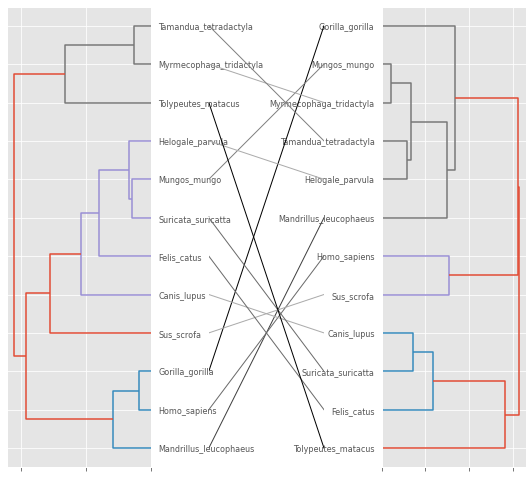

In [318]:
# Plot tanglegram
fig = tg.gen_tangle(mat1, mat2, optimize_order=True)

plt.savefig(output_fig_dir+"tanglegram_P_copri.png",dpi=900, bbox_inches="tight")
plt.show()

In [48]:
type(fig)

matplotlib.figure.Figure

INFO  : Generating linkage from dataframe (tanglegram.tangle)
INFO  : Generating linkage from dataframe (tanglegram.tangle)
/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/tanglegram/tangle.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=8)
/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/tanglegram/tangle.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=8)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


<class 'list'>
<class 'pandas.core.frame.DataFrame'>


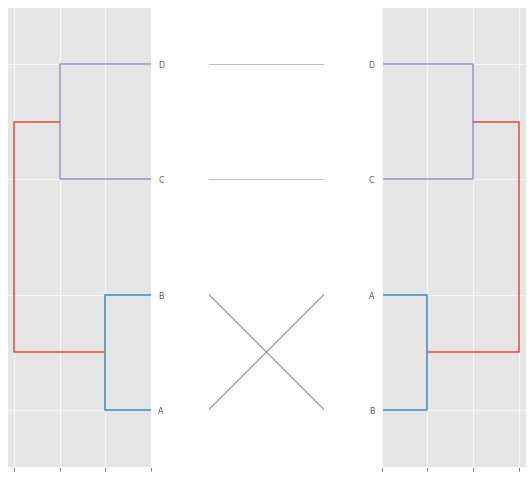

In [39]:
labelsA= ['A', 'B', 'C', 'D']
labelsB= ['B', 'A', 'C', 'D']
data = [[ 0,  .1,  .4, .3],
        [.1,   0,  .5, .6],
        [ .4, .5,   0, .2],
        [ .3, .6,  .2,  0]]

print(type(data))

mat1 = pd.DataFrame(data,
                    columns=labelsA,
                    index=labelsA)

mat2 = pd.DataFrame(data,
                    columns=labelsB,
                    index=labelsB)
print(type(mat2))

# Plot tanglegram
fig = tg.gen_tangle(mat1, mat2, optimize_order=False)
plt.show()

In [115]:
help(tg.gen_tangle)

Help on function gen_tangle in module tanglegram.tangle:

gen_tangle(a, b, labelsA=None, labelsB=None, optimize_order=10000, color_by_diff=True, link_kwargs={}, dend_kwargs={})
    Plots a tanglegram from two dendrograms.
    
    Parameters
    ----------
    (a,b) :                 pandas.DataFrame | scipy.cluster.hierarchy.linkage
                            Dendrograms to be compared. If DataFrame, will be
                            considered a distance matrix and linkage is
                            generated (see ``link_kwargs``).
    (labelsA,labelsB) :     list of str
                            If not provided and a/b are pandas Dataframes,
                            will try to extract from columns.
    optimize_order :        bool | int, optional
                            If not False, will try rearranging dendrogram to
                            optimise pairing of similar values. Currently uses
                            brute force approach -> might give varying 

# Visualize tree with metadata 

In [ ]:
trees = Phylo.parse(sample_tree_fp, 'newick')
# help(Phylo.parse)
Phylo.draw(trees)